In [1]:
# this notebook is for producing backtest data with the Dixon-Coles algorithm

# the first part of it uses a single-threaded process to create a data frame you can test on
# if you're looking to quickly(ish) create saved data you can backtest against, then skip down to the multiprocess bit

import pandas as pd
import numpy as np
from scipy.stats import skellam
from bettools import (
    get_data,
    generate_seasons,
    calculate_poisson_match_outcomes,
    calculate_ev_from_odds,
    kelly_criterion,
)
import warnings
from dixon_coles import (
    solve_parameters_decay,
    get_1x2_probs,
    dixon_coles_simulate_match,
    make_betting_prediction,
)

from concurrent.futures import ProcessPoolExecutor
from process_chunk import process_chunk
from tqdm import tqdm
import os

# Suppress RuntimeWarnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.options.mode.chained_assignment = None

In [3]:
leagues = ["E0"]

season_list = generate_seasons(2020, 2024)

df_ls = get_data(season_list, leagues)

main_df = pd.concat(df_ls)

main_df["Date"] = pd.to_datetime(main_df["Date"])
main_df = main_df.sort_values("Date")
main_df.set_index("Date", inplace=True)

In [4]:
def walk_forward_validation(data, initial_train_size, test_size, num_iterations):
    
    total_rows = len(data)
    train_start = 0
    train_end = initial_train_size
    test_end = train_end + test_size

    results = []
    iteration = 0  # To track the number of iterations
    while test_end <= total_rows and iteration < num_iterations:
        # Splitting the data
        train_data = data.iloc[train_start:train_end]
        test_data = data.iloc[train_end:test_end]

        # Calculating time difference from the end of the training set
        max_train_date = train_data.index.max()
        train_data["time_diff"] = (max_train_date - train_data.index).days

        # Selecting columns (adjust as necessary)
        train_data = train_data[["HomeTeam", "AwayTeam", "FTHG", "FTAG", "time_diff"]]

        successful_fit = False
        attempts = 0
        while (
            not successful_fit and attempts < 5
        ):  # Try fitting parameters up to 2 times
            try:
                params = solve_parameters_decay(train_data, xi=0.00325)
                # Insert your prediction and evaluation logic here, using `params`
                # For each row in test_data, calculate predictions and append to test_data
                test_data = test_data.reset_index()
                for i in range(len(test_data)):
                    home_team = test_data.loc[i]["HomeTeam"]
                    away_team = test_data.loc[i]["AwayTeam"]
                    probs_1x2 = get_1x2_probs(
                        dixon_coles_simulate_match(
                            params, home_team, away_team, max_goals=10
                        )
                    )
                    test_data.loc[i, "home_win_prob"] = probs_1x2["H"]
                    test_data.loc[i, "away_win_prob"] = probs_1x2["A"]
                    test_data.loc[i, "draw_win_prob"] = probs_1x2["D"]
                results.append(test_data)
                successful_fit = True
            except Exception as e:
                # If parameter fitting fails, add more data to the training set and try again
                print(
                    f"Parameter fitting failed on attempt {attempts + 1}: {e}. Trying with a larger training set."
                )
                train_end += test_size  # Expanding the training set window
                if train_end + test_size > total_rows:
                    print(
                        "Not enough data to expand the training set and perform another test. Stopping."
                    )
                    return results
                train_data = data.iloc[train_start:train_end]
                train_data["time_diff"] = (max_train_date - train_data.index).days
                train_data = train_data[
                    ["HomeTeam", "AwayTeam", "FTHG", "FTAG", "time_diff"]
                ]
                attempts += 1
        if successful_fit:
            # Move the window forward
            train_end = test_end
            test_end += test_size
            iteration += 1  # Increment the iteration count
    return results

In [6]:
res = walk_forward_validation(main_df, 500, 10, 5)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 712.6257163196813
            Iterations: 53
            Function evaluations: 2661
            Gradient evaluations: 53
Optimization terminated successfully    (Exit mode 0)
            Current function value: 715.8252026087489
            Iterations: 64
            Function evaluations: 3219
            Gradient evaluations: 64
Optimization terminated successfully    (Exit mode 0)
            Current function value: 731.1487292197318
            Iterations: 62
            Function evaluations: 3118
            Gradient evaluations: 62
Optimization terminated successfully    (Exit mode 0)
            Current function value: 742.927934214639
            Iterations: 48
            Function evaluations: 2419
            Gradient evaluations: 48
Optimization terminated successfully    (Exit mode 0)
            Current function value: 761.8525293215994
            Iterations: 58
            Function e

In [20]:
results_df = pd.concat(res)
results_df.reset_index(inplace=True, drop=True)

In [12]:
directory = 'data'

# List to hold the data from each CSV
data_frames = []

# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        # Read the CSV file
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path, index_col=0)
        # Append the DataFrame to the list
        data_frames.append(df)

results_df = pd.concat(data_frames)
results_df.reset_index(inplace=True, drop=True)

In [16]:
len(results_df)

34590

In [14]:
results_df["home_ev"] = results_df.apply(
    lambda x: calculate_ev_from_odds(x["home_max_odds"], x["home_win_prob"]), axis=1
)
results_df["away_ev"] = results_df.apply(
    lambda x: calculate_ev_from_odds(x["away_max_odds"], x["away_win_prob"]), axis=1
)
results_df["draw_ev"] = results_df.apply(
    lambda x: calculate_ev_from_odds(x["draw_max_odds"], x["draw_win_prob"]), axis=1
)

<Axes: >

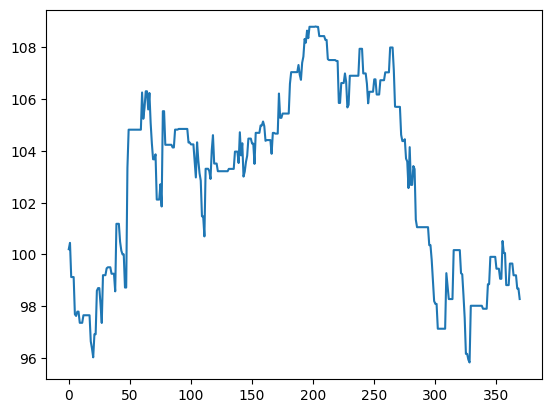

In [17]:
bankroll = 100

for i in range(len(results_df)):
    bet_size = kelly_criterion(
        results_df.loc[i]["home_win_prob"], results_df.loc[i]["home_max_odds"], bankroll, 0.05
    )
    bankroll = bankroll - bet_size
    if results_df.loc[i]["FTHG"] > results_df.loc[i]["FTAG"]:
        bankroll = bankroll + bet_size * results_df.loc[i]["home_max_odds"]
    results_df.loc[i, "bankroll"] = bankroll

results_df.bankroll.plot()

<Axes: >

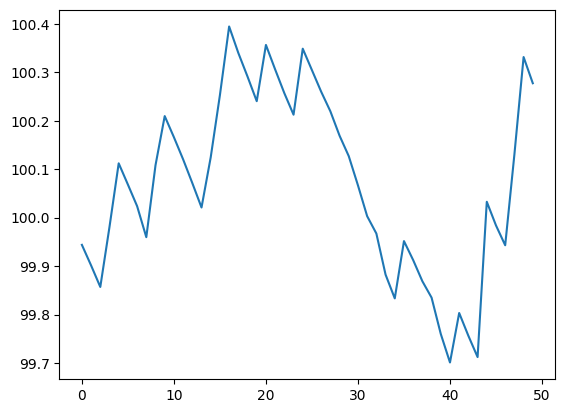

In [25]:
bankroll = 100

for i in range(len(results_df)):
    bet_size = kelly_criterion(
        results_df.loc[i]["draw_max_odds"], bankroll, results_df.loc[i]["draw_win_prob"], 0.05
    )
    bankroll = bankroll - bet_size
    if results_df.loc[i]["FTHG"] == results_df.loc[i]["FTAG"]:
        bankroll = bankroll + bet_size * results_df.loc[i]["draw_max_odds"]
    results_df.loc[i, "bankroll"] = bankroll

results_df.bankroll.plot()

<Axes: >

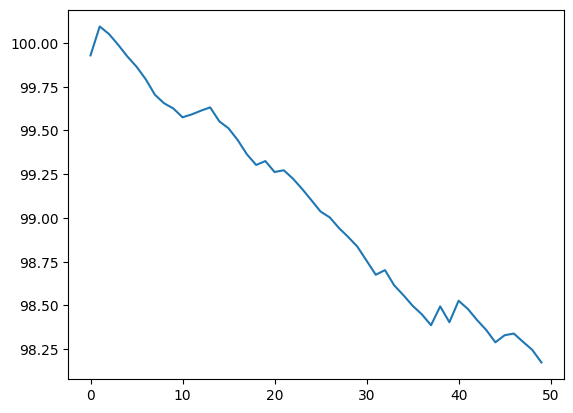

In [26]:
bankroll = 100

for i in range(len(results_df)):
    bet_size = kelly_criterion(
        results_df.loc[i]["away_max_odds"], bankroll, results_df.loc[i]["away_win_prob"], 0.05
    )
    bankroll = bankroll - bet_size
    if results_df.loc[i]["FTHG"] < results_df.loc[i]["FTAG"]:
        bankroll = bankroll + bet_size * results_df.loc[i]["away_max_odds"]
    results_df.loc[i, "bankroll"] = bankroll

results_df.bankroll.plot()

In [31]:
# be warned - this takes a long time!

def walk_forward_validation_parallel(data, initial_train_size, test_size, num_iterations):
    total_rows = len(data)
    
    # Calculate the start and end indices for each chunk
    indices = [(i*test_size, initial_train_size + i*test_size, test_size) for i in range(num_iterations) if initial_train_size + (i+1)*test_size <= total_rows]
    
    with ProcessPoolExecutor(max_workers=7) as executor:
        # Prepare a list of tasks
        tasks = [(data, *idx) for idx in indices]
        # Setup progress bar with total equal to the number of tasks
        progress_bar = tqdm(total=len(tasks), desc="Processing Chunks")

        # Execute tasks and update progress bar as each task completes
        results = []
        for _ in executor.map(process_chunk, tasks):
            progress_bar.update(1)  # Update progress for each completed task
            results.append(_)  # Store result (optional, depending on your needs)
        
        # Close the progress bar upon completion
        progress_bar.close()

    return results

In [35]:
leagues = [['E0'],['E1']]
for league in leagues:
    season_list = generate_seasons(2022, 2024)
    df_ls = get_data(season_list, league)
    main_df = pd.concat(df_ls)
    main_df = main_df.dropna()
    main_df['Date'] = pd.to_datetime(main_df['Date'])
    main_df = main_df.sort_values('Date')
    main_df.set_index('Date', inplace=True)
    res = walk_forward_validation_parallel(main_df, 500, 10, int((len(main_df)-500)/10))
    results = pd.concat(res)
    results.to_csv(f'data/results_dc_{league}.csv')

Processing Chunks: 100%|██████████████████████████| 22/22 [11:06<00:00, 30.29s/it]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 759.2940540806734
            Iterations: 46
            Function evaluations: 2318
            Gradient evaluations: 46
Optimization terminated successfully    (Exit mode 0)
            Current function value: 770.6530288088579
            Iterations: 46
            Function evaluations: 2319
            Gradient evaluations: 46
Optimization terminated successfully    (Exit mode 0)
            Current function value: 797.1708230652115
            Iterations: 53
            Function evaluations: 2672
            Gradient evaluations: 53
Optimization terminated successfully    (Exit mode 0)
            Current function value: 766.836109442473
            Iterations: 47
            Function evaluations: 2367
            Gradient evaluations: 47
Optimization terminated successfully    (Exit mode 0)
            Current function value: 753.2844318015917
            Iterations: 48
            Function e

In [18]:
rs_ls = []
files = os.listdir('data')

for file in files:
    if '.csv' in file:
        results = pd.read_csv(f'data/{file}', index_col=0)
        results.drop(columns=["index"], inplace=True)
        results["Date"] = pd.to_datetime(results["Date"])
        results.sort_values(by="Date", inplace=True)
        results.dropna(inplace=True)
        results.reset_index(inplace=True, drop=True)
        rs_ls.append(results)

results = pd.concat(rs_ls)

results = results.sort_values(by="Date")
results.reset_index(inplace=True, drop=True)

<Axes: >

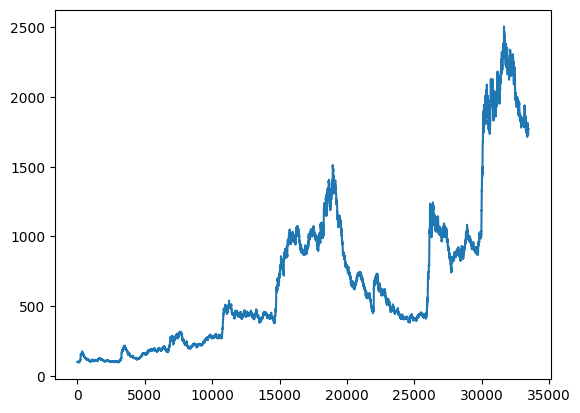

In [19]:
results["home_ev"] = results.apply(
    lambda x: calculate_ev_from_odds(x["home_max_odds"], x["home_win_prob"]), axis=1
)
results["away_ev"] = results.apply(
    lambda x: calculate_ev_from_odds(x["away_max_odds"], x["away_win_prob"]), axis=1
)
results["draw_ev"] = results.apply(
    lambda x: calculate_ev_from_odds(x["draw_max_odds"], x["draw_win_prob"]), axis=1
)

bankroll = 100

for i in range(len(results)):
    bet_size = kelly_criterion(
        results.loc[i]["home_win_prob"], results.loc[i]["home_max_odds"], bankroll, 0.05
    )
    bankroll = bankroll - bet_size
    if results.loc[i]["FTHG"] > results.loc[i]["FTAG"]:
        bankroll = bankroll + bet_size * results.loc[i]["home_max_odds"]
    results.loc[i, "bankroll"] = bankroll

results.bankroll.plot()

<Axes: >

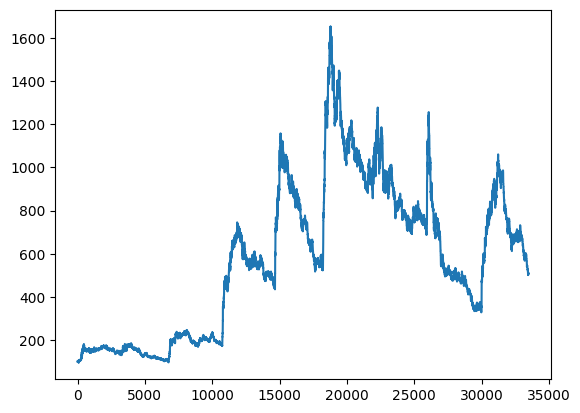

In [20]:
bankroll = 100

for i in range(len(results)):
    bet_size = kelly_criterion(
        results.loc[i]["away_win_prob"], results.loc[i]["away_max_odds"], bankroll, 0.05
    )
    bankroll = bankroll - bet_size
    if results.loc[i]["FTHG"] < results.loc[i]["FTAG"]:
        bankroll = bankroll + bet_size * results.loc[i]["away_max_odds"]
    results.loc[i, "bankroll"] = bankroll

results.bankroll.plot()

<Axes: >

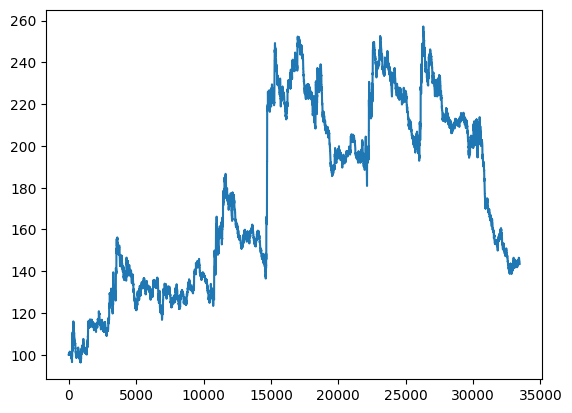

In [21]:
bankroll = 100

for i in range(len(results)):
    bet_size = kelly_criterion(
        results.loc[i]["draw_win_prob"], results.loc[i]["draw_max_odds"], bankroll, 0.05
    )
    bankroll = bankroll - bet_size
    if results.loc[i]["FTHG"] == results.loc[i]["FTAG"]:
        bankroll = bankroll + bet_size * results.loc[i]["draw_max_odds"]
    results.loc[i, "bankroll"] = bankroll

results.bankroll.plot()

<Axes: >

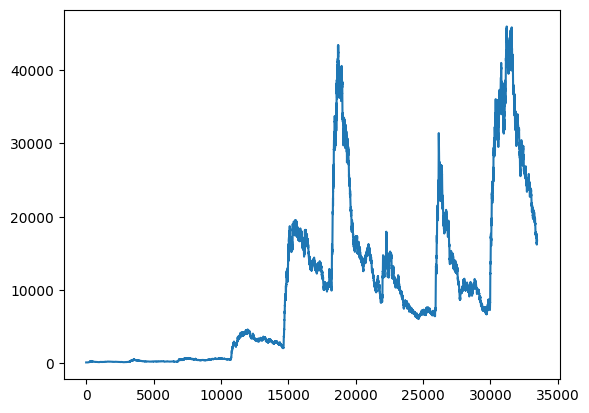

In [22]:
bankroll = 100
KELLY_FRACTION = 0.05

MIN_VALUE = 0
MAX_VALUE = 100

MAX_BET = 100

for i in range(len(results)):
    max_value = max(
        results.loc[i]["home_ev"], results.loc[i]["away_ev"], results.loc[i]["draw_ev"]
    )
    if max_value > MIN_VALUE and max_value < MAX_VALUE:
        if results.loc[i]["home_ev"] == max_value:
            bet_size = kelly_criterion(
                results.loc[i]["home_win_prob"],
                results.loc[i]["home_max_odds"],
                bankroll,
                KELLY_FRACTION,
            )
            bankroll = bankroll - bet_size
            if results.loc[i]["FTHG"] > results.loc[i]["FTAG"]:
                bankroll = bankroll + bet_size * results.loc[i]["home_max_odds"]
            results.loc[i, "bankroll"] = bankroll
        elif results.loc[i]["away_ev"] == max_value:
            bet_size = kelly_criterion(
                results.loc[i]["away_win_prob"],
                results.loc[i]["away_max_odds"],
                bankroll,
                KELLY_FRACTION,
            )
            bankroll = bankroll - bet_size
            if results.loc[i]["FTHG"] < results.loc[i]["FTAG"]:
                bankroll = bankroll + bet_size * results.loc[i]["away_max_odds"]
            results.loc[i, "bankroll"] = bankroll
        else:
            bet_size = kelly_criterion(
                results.loc[i]["draw_win_prob"],
                results.loc[i]["draw_max_odds"],
                bankroll,
                KELLY_FRACTION,
            )
            bankroll = bankroll - bet_size
            if results.loc[i]["FTHG"] == results.loc[i]["FTAG"]:
                bankroll = bankroll + bet_size * results.loc[i]["draw_max_odds"]
            results.loc[i, "bankroll"] = bankroll
    else:
        results.loc[i, "bankroll"] = bankroll
results.bankroll.plot()

In [23]:
bankroll

16771.214394331768